In [3]:
%matplotlib auto

%cd '/jetfs/home/a12233665/pai-munich-vienna/'
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from datetime import datetime
from joblib import Parallel, delayed
from numba import njit
import xarray as xr
from pathlib import Path

from xgrads import open_CtlDataset, CtlDescriptor

from kendapy.ekf import Ekf
from enstools.io import read, write

#import pai.localization as loc
from pai.localization import get_dist_from_obs, gaspari_cohn, vertical_dist, haversine_distance
import pai.localization as loc
import pai.pai_utils as paiut
import pai.observation as oi
import pai.PAI_Optimize_GC as paiogc
import pai.partial_analysis_increment_np as PAI
import sys
sys.path.append('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/')
import Plotting.Plot_Functions as pf

import os
import cProfile, pstats, io
from pstats import SortKey
import time
import copy



from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

Using matplotlib backend: agg
/jetfs/home/a12233665/pai-munich-vienna


In [4]:
def resilience(exp_path, dir_time_sonde, sonde_time, dir_time_ana, ana_time, rep_index, save_name, influencing_obs = 'RADAR', influencing_var = 'RREFL', BT_choice_influencer = 0, sat_var = 'REFL', BT_choice_sat = 0, RTPP = True, Title = 'Explanatory_Plot', surface_vloc = 0.2, Surface_Peak = False, vars = ['t', 'q'], obs_var = 'T', save = True, read_stored_file = True, read_diag_file = True, diag_set = []):
    obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time_ana, ana_time)
    obs_path_TEMP = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time_ana, ana_time)
    obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time_sonde, sonde_time)
    obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
    obs_path_INFLUENCER = '{}/feedback/{}/ekf{}.nc.{}'.format(exp_path, dir_time_ana, influencing_obs, ana_time)
    ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, dir_time_ana, ana_time)
    hloc_path = '{}/feedback/{}/monDIAG.nc.{}.ctl'.format(exp_path, dir_time_ana, ana_time)
    print(hloc_path)

    if os.path.isfile(obs_path_TEMP2) == True:
        obs_sonde_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
    obs_sonde_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
    if rep_index < len(obs_sonde_T1.reports()):
        rep = obs_sonde_T1.reports()[rep_index]
        obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
    else:
        rep = obs_sonde_T2.reports()[rep_index - len(obs_sonde_T1.reports())]
        obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
    print(rep)
    obs_sonde_T.add_filter(filter=f"report={rep}")
    obslon = obs_sonde_T.obs(param="lon")[0]
    obslat = obs_sonde_T.obs(param="lat")[0]
    rot_lons, rot_lats = oi.location_to_rotated_pole([obslon, obslon], [obslat, obslat])

    mean = paiut.read_grib(ana_path, vars).isel(time=0) 
    buffer = 0.04
    mean2 = loc.find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, mean.clon, mean.clat, mean)
    mean2 = mean2.thin({'generalVerticalLayer': 4})
    if read_stored_file == False:
        ens = paiut.read_grib_mf(ana_path, ana_time, vars)
        ens2 = loc.find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, ens.clon, ens.clat, ens)
        ensperturb = ens2 - mean2
        ensperturb.to_netcdf('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(rep_index))
        del ensperturb
    
    ensperturb = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(rep_index))
    ensperturb = ensperturb.thin({'generalVerticalLayer': 4})

    ## Get horizontal localisation factor
    # load the data into xarray.Dataset
    if read_diag_file == True:
        ctl = open_CtlDataset(hloc_path).isel(time=0)
        LAT, LON = np.meshgrid(ctl.lat.values, ctl.lon.values)
        CLON, CLAT = oi.rotated_pole_to_location(LON.flatten(), LAT.flatten())
        CLON = CLON.reshape(LON.shape)
        CLAT = CLAT.reshape(LAT.shape)
        ctl = ctl.assign_coords(clat=(("lon", "lat"), CLAT))
        ctl = ctl.assign_coords(clon=(("lon", "lat"), CLON))
    else:
        ctl = diag_set
        CLAT = ctl.clat.values
        CLON = ctl.clon.values
    h_loc = 15
    dist = get_dist_from_obs(
        ctl.clat.values, ctl.clon.values, obslat, obslon, h_loc #np.array(ana_mean.clat), np.array(ana_mean.clon), float(obs.data.lat), float(obs.data.lon), h_loc
    )
    closest = np.argmin(dist)
    print(closest)
    h_loc = ctl.where((ctl.clat==CLAT.flatten()[closest])*(ctl.clon==CLON.flatten()[closest]), drop = True).isel(lat =0, lon=0).rlh_1

    mean_pres = mean2.pres.mean(dim='cell').values/100
    closest_coarse_level = [np.argmin(np.abs(mean_pres[i] - h_loc.lev.values)) for i in range(len(mean_pres))]
    mean2 = mean2.assign(hloc=h_loc.values[closest_coarse_level])
    
    infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=25.0)

    infl_reg_latlon_RAD = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]

    print("get obs batch")

    obs_batch_RAD = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon_RAD, obsvar=sat_var, new_loc = False, RAWBT_choice = BT_choice_sat)#, RTPP_correction=RTPP)
    # If looking at obs with adaptive horizontal loc, need potentially more observations
    if influencing_var == 'RADVEL':
        infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=16)
        infl_reg_latlon = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print(influencing_obs)
    elif influencing_var == 'RREFL':
        infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=16)
        infl_reg_latlon = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print(influencing_obs)
    elif influencing_obs != 'RAD':
        infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=np.max(h_loc.values))
        infl_reg_latlon = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print('Treated as conventional')
        print(np.max(h_loc.values))
    else:
        infl_reg_latlon = infl_reg_latlon_RAD
    obs_batch_INFLUENCER = paiut.get_obs_batch(obs_path_INFLUENCER, *infl_reg_latlon, obsvar=influencing_var, new_loc = False, RAWBT_choice = BT_choice_influencer)#, RTPP_correction=RTPP)
    if influencing_obs != 'RAD':
        if influencing_obs != 'RADAR':
            for obs in obs_batch_INFLUENCER:
                obs['vloc'] = 0.3
    print(len(obs_batch_INFLUENCER), ' obs that could influence')
    ekf_RAD = paiut.get_ekf(obs_path_RAD, sat_var, *infl_reg_latlon_RAD, whole_domain = False, active = True)
    Y_a_X_form = [np.moveaxis(np.array([ekf_RAD.anaens()]), [1,2], [0,1])]
    Y_a_X_form = [x - x.mean(axis = 0, keepdims = True) for x in Y_a_X_form]

    vars = ['t']
    
    lats = ensperturb.clat.values
    lons = ensperturb.clon.values
    error_list = []
    vertical_list = []
    obs_batch_RAD_change = copy.deepcopy(obs_batch_RAD)
    print(Y_a_X_form[0].shape)
    pressure_levels = mean2.pres.values
    perturbvars = [ensperturb[var].values for var in vars]
    incr = paiogc.pai_loop_over_obs_slow(
            obs_batch_RAD,
            ['t'],
            lons,
            lats,
            perturbvars,
            pressure_levels,
            40
        )
    for vert_index in range(len(mean_pres)):
        print(vert_index)
        for obs in obs_batch_INFLUENCER:
            if influencing_obs == 'RAD':
                obs['hloc'] = 25
            elif influencing_obs == 'RADVEL':
                obs['hloc'] = 16
            elif influencing_obs == 'RREFL':
                obs['hloc'] = 16
            else:
                obs['hloc'] = mean2.hloc.values[vert_index]
        print(mean_pres[vert_index]*100)
        #obs = obs_batch_INFLUENCER[0]
        print([obs["obspres"] for obs in obs_batch_INFLUENCER])
        print([obs["vloc"] for obs in obs_batch_INFLUENCER])
        #print(PAI.compute_vloc(obs["obspres"] / 100.0, obs["vloc"], np.array([mean_pres[vert_index]*100]*np.ones((1, 1))) / 100.0))
        E_times_departure = paiogc.pai_loop_over_obs_slow(
            obs_batch_INFLUENCER,
            ['t'],
            np.array([obs_sonde_T.obs(param='lon')[0]]),
            np.array([obs_sonde_T.obs(param='lat')[0]]),
            Y_a_X_form,
            np.array([mean_pres[vert_index]*100]*np.ones((Y_a_X_form[0].shape[1], 1))),
            40
        )
        #print(E_times_departure)
        print(len(E_times_departure[0][1]))
        print(len(obs_batch_RAD_change))
        perturbvars = [ensperturb[var].values[:, [vert_index], :] for var in vars]
        pressure_levels = np.array(mean2.pres.values)[[vert_index], :]
        for obs_index, obs in enumerate(obs_batch_RAD_change):
            obs['fgmeandep'] = E_times_departure[0][1][obs_index]
        error_term = paiogc.pai_loop_over_obs_slow(
            obs_batch_RAD_change,
            ['t'],
            lons,
            lats,
            perturbvars,
            pressure_levels,
            40,
        )
        print(error_term)
        error_list.append(error_term[0][1])
        vertical_list.append(mean_pres[vert_index])
    fig, ax = plt.subplots()
    ax.plot([x[0][0] for x in error_list], vertical_list, label = 'Error Term')
    ax.plot(incr[0][1][:,0], vertical_list, label = 'Increment')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (hPa)')
    ax.legend()
    ax.invert_yaxis()
    return error_list, vertical_list, incr

In [12]:
def resilience_components(exp_path, dir_time_sonde, sonde_time, dir_time_ana, ana_time, rep_index, save_name, influencing_obs = 'RADAR', influencing_var = 'RREFL', BT_choice_influencer = 0, sat_var = 'REFL', BT_choice_sat = 0, RTPP = True, Title = 'Explanatory_Plot', surface_vloc = 0.2, Surface_Peak = False, vars = ['t', 'q'], obs_var = 'T', save = True, read_stored_file = True, read_diag_file = True, diag_set = []):
    obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time_ana, ana_time)
    obs_path_TEMP = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time_ana, ana_time)
    obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time_sonde, sonde_time)
    obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
    obs_path_INFLUENCER = '{}/feedback/{}/ekf{}.nc.{}'.format(exp_path, dir_time_ana, influencing_obs, ana_time)
    ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, dir_time_ana, ana_time)
    hloc_path = '{}/feedback/{}/monDIAG.nc.{}.ctl'.format(exp_path, dir_time_ana, ana_time)
    print(hloc_path)

    if os.path.isfile(obs_path_TEMP2) == True:
        obs_sonde_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
    obs_sonde_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
    if rep_index < len(obs_sonde_T1.reports()):
        rep = obs_sonde_T1.reports()[rep_index]
        obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
    else:
        rep = obs_sonde_T2.reports()[rep_index - len(obs_sonde_T1.reports())]
        obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
    print(rep)
    obs_sonde_T.add_filter(filter=f"report={rep}")
    obslon = obs_sonde_T.obs(param="lon")[0]
    obslat = obs_sonde_T.obs(param="lat")[0]
    rot_lons, rot_lats = oi.location_to_rotated_pole([obslon, obslon], [obslat, obslat])

    mean = paiut.read_grib(ana_path, vars).isel(time=0) 
    buffer = 0.04
    mean2 = loc.find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, mean.clon, mean.clat, mean)
    mean2 = mean2.thin({'generalVerticalLayer': 4})
    ## Get horizontal localisation factor
    # load the data into xarray.Dataset
    if read_diag_file == True:
        ctl = open_CtlDataset(hloc_path).isel(time=0)
        LAT, LON = np.meshgrid(ctl.lat.values, ctl.lon.values)
        CLON, CLAT = oi.rotated_pole_to_location(LON.flatten(), LAT.flatten())
        CLON = CLON.reshape(LON.shape)
        CLAT = CLAT.reshape(LAT.shape)
        ctl = ctl.assign_coords(clat=(("lon", "lat"), CLAT))
        ctl = ctl.assign_coords(clon=(("lon", "lat"), CLON))
    else:
        ctl = diag_set
        CLAT = ctl.clat.values
        CLON = ctl.clon.values
    h_loc = 15
    dist = get_dist_from_obs(
        ctl.clat.values, ctl.clon.values, obslat, obslon, h_loc #np.array(ana_mean.clat), np.array(ana_mean.clon), float(obs.data.lat), float(obs.data.lon), h_loc
    )
    closest = np.argmin(dist)
    print(closest)
    h_loc = ctl.where((ctl.clat==CLAT.flatten()[closest])*(ctl.clon==CLON.flatten()[closest]), drop = True).isel(lat =0, lon=0).rlh_1

    mean_pres = mean2.pres.mean(dim='cell').values/100
    closest_coarse_level = [np.argmin(np.abs(mean_pres[i] - h_loc.lev.values)) for i in range(len(mean_pres))]
    mean2 = mean2.assign(hloc=h_loc.values[closest_coarse_level])
    
    infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=25.0)

    infl_reg_latlon_RAD = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]

    print("get obs batch")

    obs_batch_RAD = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon_RAD, obsvar=sat_var, new_loc = False, RAWBT_choice = BT_choice_sat)#, RTPP_correction=RTPP)
    # If looking at obs with adaptive horizontal loc, need potentially more observations
    if influencing_var == 'RADVEL':
        infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=16)
        infl_reg_latlon = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print(influencing_obs)
    elif influencing_var == 'RREFL':
        infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=16)
        infl_reg_latlon = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print(influencing_obs)
    elif influencing_obs != 'RAD':
        infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=np.max(h_loc.values))
        infl_reg_latlon = np.array(oi.rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()#[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print('Treated as conventional')
        print(np.max(h_loc.values))
    else:
        infl_reg_latlon = infl_reg_latlon_RAD
    obs_batch_INFLUENCER = paiut.get_obs_batch(obs_path_INFLUENCER, *infl_reg_latlon, obsvar=influencing_var, new_loc = False, RAWBT_choice = BT_choice_influencer)#, RTPP_correction=RTPP)
    if influencing_obs != 'RAD':
        if influencing_obs != 'RADAR':
            for obs in obs_batch_INFLUENCER:
                obs['vloc'] = 0.3
    print(len(obs_batch_INFLUENCER), ' obs that could influence')
    ekf_RAD = paiut.get_ekf(obs_path_RAD, sat_var, *infl_reg_latlon_RAD, whole_domain = False, active = True)
    Y_a_X_form = [np.moveaxis(np.array([ekf_RAD.anaens()]), [1,2], [0,1])]
    Y_a_X_form = [x - x.mean(axis = 0, keepdims = True) for x in Y_a_X_form]

    vars = ['t']
    error_list = []
    vertical_list = []
    obs_batch_RAD_change = copy.deepcopy(obs_batch_RAD)
    print(Y_a_X_form[0].shape)
    pressure_levels = mean2.pres.values
    for vert_index in range(len(mean_pres)):
        print(vert_index)
        for obs in obs_batch_INFLUENCER:
            if influencing_obs == 'RAD':
                obs['hloc'] = 25
            elif influencing_obs == 'RADVEL':
                obs['hloc'] = 16
            elif influencing_obs == 'RREFL':
                obs['hloc'] = 16
            else:
                obs['hloc'] = mean2.hloc.values[vert_index]
        print(mean_pres[vert_index]*100)
        #obs = obs_batch_INFLUENCER[0]
        print([obs["obspres"] for obs in obs_batch_INFLUENCER])
        print([obs["vloc"] for obs in obs_batch_INFLUENCER])
        #print(PAI.compute_vloc(obs["obspres"] / 100.0, obs["vloc"], np.array([mean_pres[vert_index]*100]*np.ones((1, 1))) / 100.0))
        print('Influencer departures: ', [obs['fgmeandep'] for obs in obs_batch_influencer])
        print('Influencer mean departure: ', np.mean(np.array([obs['fgmeandep'] for obs in obs_batch_influencer])))
        ekf_INFLUENCER = paiut.get_ekf(obs_path_INFLUENCER, sat_var, *infl_reg_latlon, whole_domain = False, active = True)
        print('Y_aY_aT: ', np.matmul(ekf_RAD.anaens(), ekf_INFLUENCER.anaens()))
        print('Y_aY_aT norm: ', np.norm(np.matmul(ekf_RAD.anaens(), ekf_INFLUENCER.anaens()), ord=2))
        E_times_departure = paiogc.pai_loop_over_obs_slow(
            obs_batch_INFLUENCER,
            ['t'],
            np.array([obs_sonde_T.obs(param='lon')[0]]),
            np.array([obs_sonde_T.obs(param='lat')[0]]),
            Y_a_X_form,
            np.array([mean_pres[vert_index]*100]*np.ones((Y_a_X_form[0].shape[1], 1))),
            40
        )
        print(E_times_departure)
    #return error_list, vertical_list, incr

In [3]:
%matplotlib inline
def plot_PAI_errors(rep_index):
    Comparison_dataset = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/New_Compare_influencers_big_' + str(rep_index) + '.nc')
    label_size = 20
    fig, ax = plt.subplots(figsize=(5, 9))
    for inf_obs in Comparison_dataset.influencing_obs.values:
        print(inf_obs)
        ax.plot(Comparison_dataset.where(Comparison_dataset.influencing_obs==inf_obs, drop = True).PAI_error.values[0, :, 0], 
                                    Comparison_dataset.plevel.values, label=inf_obs, alpha = 0.5, linewidth = 1)
    #ax.plot(Comparison_dataset.sum(dim='Influencer').PAI_error.values[:, 0], Comparison_dataset.plevel.values, label='total error', color = 'black')
    ax.plot(Comparison_dataset.PAI_incr.values.mean(axis = (0, 2)), Comparison_dataset.plevel.values, label = 'increment used', color = 'red')
    ax.plot(Comparison_dataset.PAI_incr.values.mean(axis = (0, 2)) - Comparison_dataset.sum(dim='Influencer').PAI_error.values[:, 0], Comparison_dataset.plevel.values, label='Second order approx of\n\'analysis with\' - \'analysis without\'', color = 'green')
    #ax.plot(Comparison_dataset.where((Comparison_dataset.influencing_obs != 'SYNOP T2M'), drop = True).sum(dim='Influencer').PAI_error.values[:, 0], Comparison_dataset.plevel.values, label = 'total error', color = 'orange')
    ax.axvline(0, color = 'black', alpha = 0.7)
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(1.05, 1), fontsize = label_size)
    ax.set_xlabel('Temperature (K)', fontsize = label_size + 1)
    ax.set_ylabel('Pressure (hPa)', fontsize = label_size + 1)
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    ax.set_title('Approximation of error\nin PAI calculation', fontsize = label_size + 2)
    fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/New_Compare_influencers_' + str(rep_index) + '.png', bbox_inches = 'tight')
#.where((Comparison_dataset.influencing_obs != 'AIREP T')*
                                 #(Comparison_dataset.influencing_obs != 'AIREP U')*
                                 #(Comparison_dataset.influencing_obs != 'AIREP V')*
                                 #(Comparison_dataset.influencing_obs != 'SYNOP T2M')

IR6.2
IR 7.3
Radar REFL
Radar RADVEL
PILOT W
PILOT T
PILOT U
PILOT V
AIREP T
AIREP U
AIREP V
AIREP RH
SYNOP PTEND
SYNOP T2M
SYNOP TD2M
SYNOP U10M
SYNOP V10M
SYNOP RH2M
IR6.2
IR 7.3
Radar REFL
Radar RADVEL
PILOT W
PILOT T
PILOT U
PILOT V
AIREP T
AIREP U
AIREP V
AIREP RH
SYNOP PTEND
SYNOP T2M
SYNOP TD2M
SYNOP U10M
SYNOP V10M
SYNOP RH2M
IR6.2
IR 7.3
Radar REFL
Radar RADVEL
PILOT W
PILOT T
PILOT U
PILOT V
AIREP T
AIREP U
AIREP V
AIREP RH
SYNOP PTEND
SYNOP T2M
SYNOP TD2M
SYNOP U10M
SYNOP V10M
SYNOP RH2M
IR6.2
IR 7.3
Radar REFL
Radar RADVEL
PILOT W
PILOT T
PILOT U
PILOT V
AIREP T
AIREP U
AIREP V
AIREP RH
SYNOP PTEND
SYNOP T2M
SYNOP TD2M
SYNOP U10M
SYNOP V10M
SYNOP RH2M
IR6.2
IR 7.3
Radar REFL
Radar RADVEL
PILOT W
PILOT T
PILOT U
PILOT V
AIREP T
AIREP U
AIREP V
AIREP RH
SYNOP PTEND
SYNOP T2M
SYNOP TD2M
SYNOP U10M
SYNOP V10M
SYNOP RH2M


FileNotFoundError: [Errno 2] No such file or directory: b'/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/New_Compare_influencers_big_14.nc'

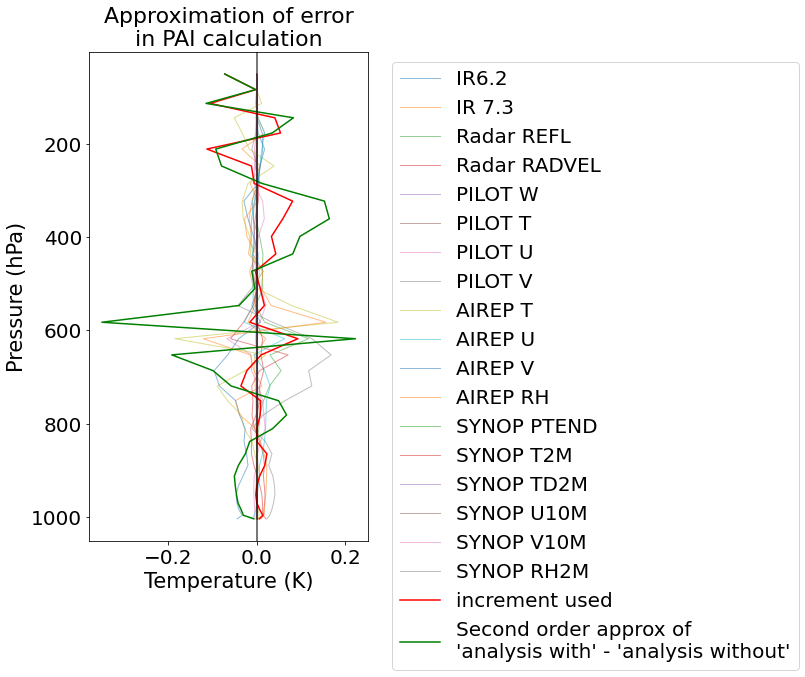

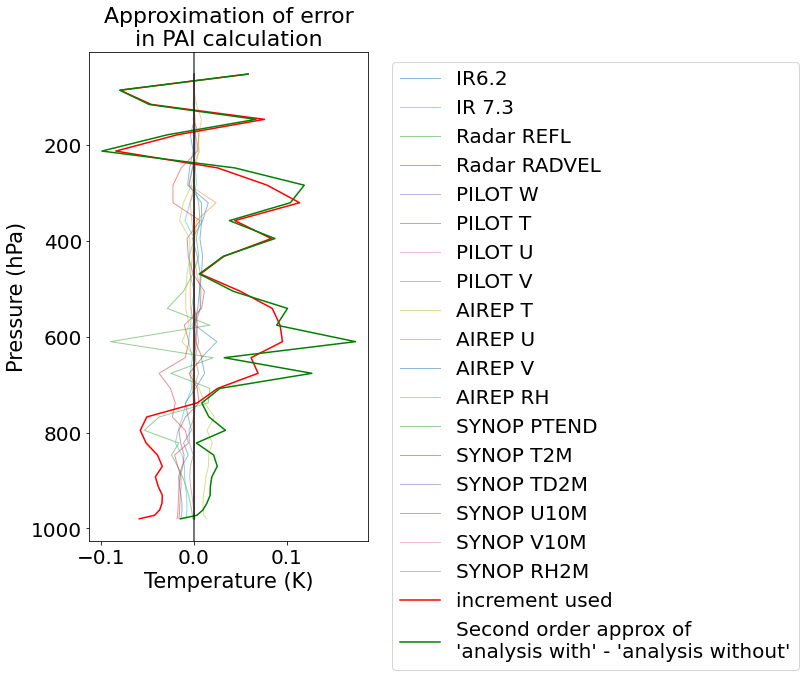

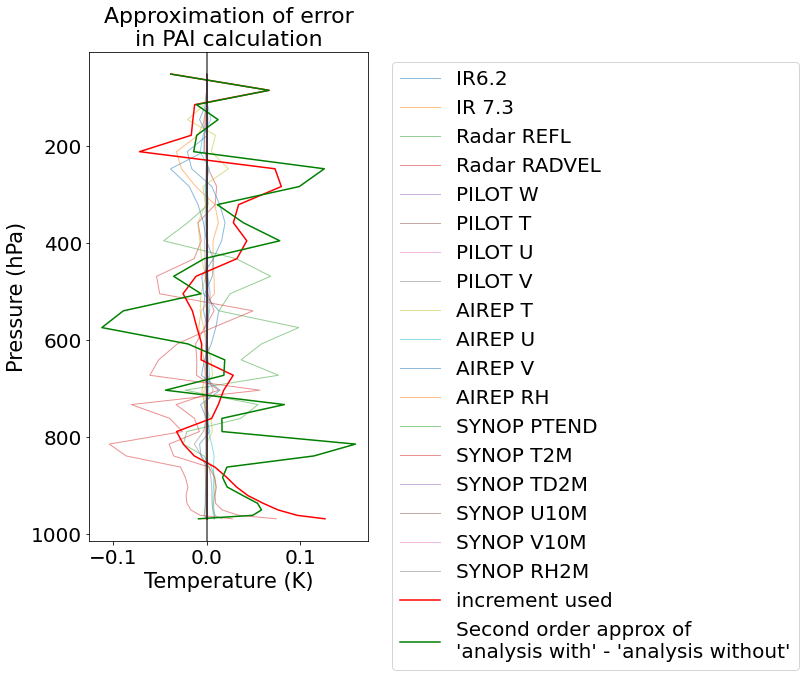

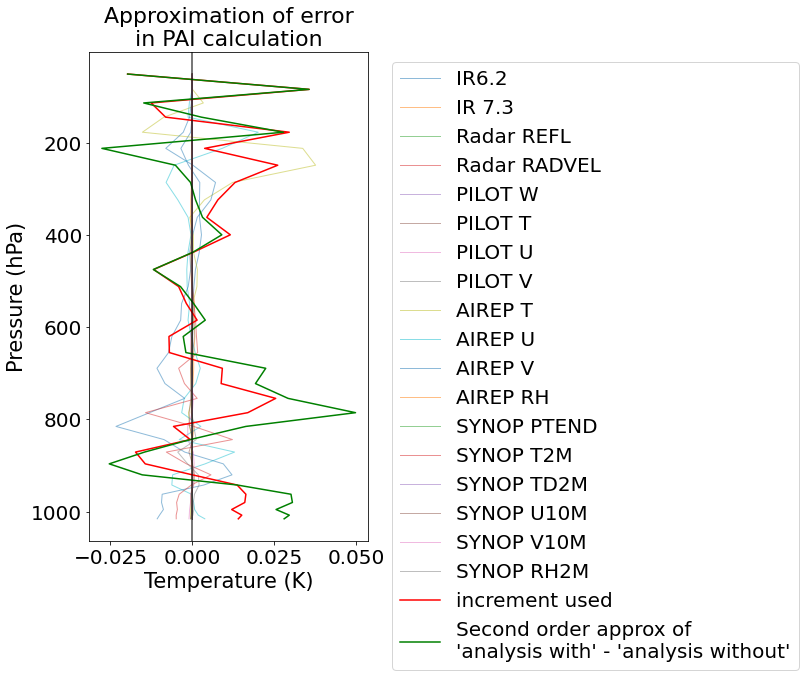

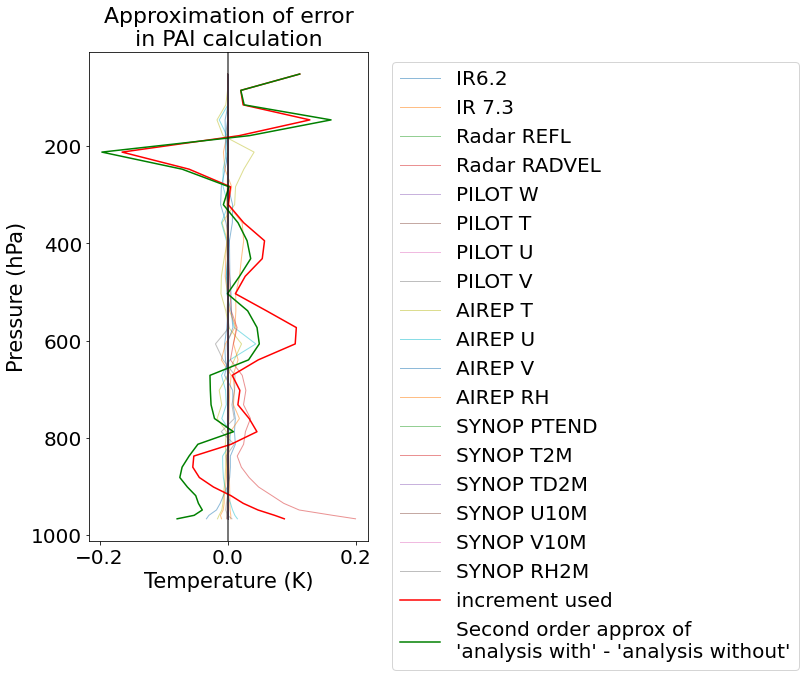

In [5]:
%matplotlib inline
plot_PAI_errors(9)
plot_PAI_errors(10)
plot_PAI_errors(11)
plot_PAI_errors(12)
plot_PAI_errors(13)


IR6.2
IR 7.3
Radar REFL
Radar RADVEL
PILOT W
PILOT T
PILOT U
PILOT V
AIREP T
AIREP U
AIREP V
AIREP RH
SYNOP PTEND
SYNOP T2M
SYNOP TD2M
SYNOP U10M
SYNOP V10M
SYNOP RH2M


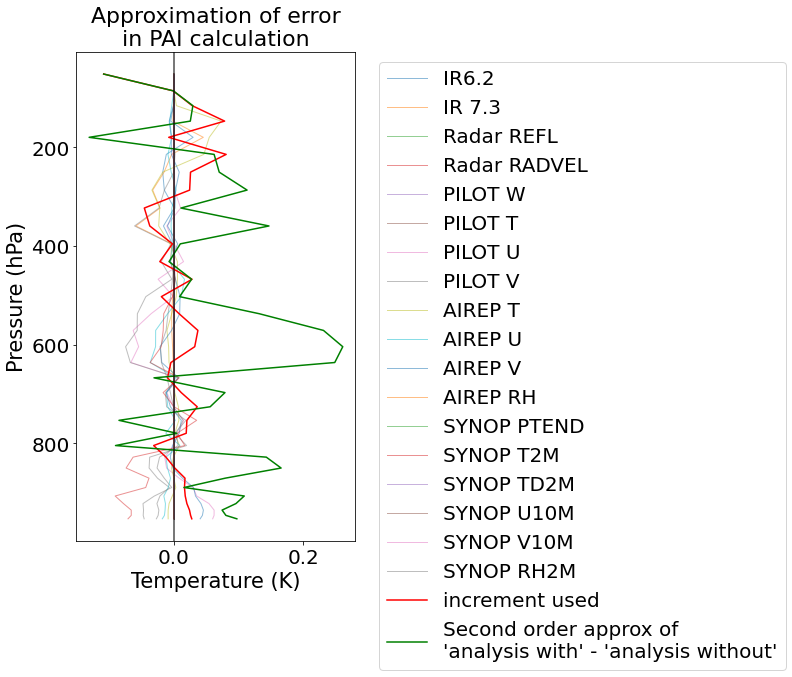

In [6]:
plot_PAI_errors(8)